# Buscar datasets de ejemplo reales

# Día 3: Tipologías de Modelos y Detección de Anomalías en Series Temporales

En este notebook cubriremos los siguientes puntos:
1. **Generación (o carga) de datos** para trabajar.
2. **Resumen de tipologías de modelos**:
   - Modelos estadísticos (ARIMA).
   - Modelo supervisado simple.
   - Modelo no supervisado (Isolation Forest).
3. **Detección de anomalías**:
   - Método estadístico simple (z-score).
   - Isolation Forest.
4. **Comparación de resultados**.
5. **Tarea** para profundizar.

**Objetivo**: Familiarizarnos con distintas categorías de modelos y aprender métodos básicos de detección de anomalías en datos temporales.


In [11]:
# Sección 0: Importaciones y Configuración

# Sección 0: Importaciones
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error

%matplotlib inline
sns.set_style("whitegrid")

print("Entorno listo para la práctica de Día 3.")



Entorno listo para la práctica de Día 3.


## Sección 1: Generación (o Carga) de Datos

Para esta práctica, generaremos de forma **sintética** una serie temporal con:
- Tendencia creciente.
- Estacionalidad mensual (aprox. 30 días).
- Ruido aleatorio.
- **Anomalías inyectadas** en ciertos puntos, para ilustrar la detección de outliers.

Si deseas usar un dataset propio o real, reemplaza la siguiente celda por una lectura de datos, por ejemplo:

```python
df = pd.read_csv("mi_dataset.csv", parse_dates=["fecha"], index_col="fecha")


In [12]:
# Sección 1: Creación de datos sintéticos con anomalías

try:
    # dataset_url = "ruta_o_url_de_tu_dataset.csv"
    # df = pd.read_csv(dataset_url, parse_dates=['fecha'], index_col='fecha')
    # Ejemplo ficticio: no implemento la lectura real.
    raise FileNotFoundError("Simulando que no tenemos el dataset real")
except FileNotFoundError:
    print("No se encontró el dataset real, generando datos sintéticos...")
    rng = pd.date_range(start='2024-01-01', periods=200, freq='D')
    np.random.seed(42)
    
    # Tendencia lineal
    trend = np.linspace(100, 200, len(rng))
    # Estacionalidad semanal
    seasonality = 10 * np.sin(2 * np.pi * np.arange(len(rng)) / 7)
    # Ruido
    noise = np.random.normal(0, 5, len(rng))
    
    # base series
    vals = trend + seasonality + noise
    
    # Inyectamos algunas anomalías
    anomaly_indices = np.random.choice(len(rng), size=5, replace=False)
    vals[anomaly_indices] += np.random.choice([30, -25], size=5)
    
    df = pd.DataFrame({'valor': vals}, index=rng)
    
df.head()



No se encontró el dataset real, generando datos sintéticos...


,valor
2024-01-01,102.483571
2024-01-02,107.629506
2024-01-03,113.992747
2024-01-04,113.461524
2024-01-05,96.500446


In [13]:
# Sección 1.1: Exploración Inicial
print("Dimensiones del DataFrame:", df.shape)
df.info()

df.describe()

Dimensiones del DataFrame: (200, 1)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 200 entries, 2024-01-01 to 2024-07-18
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   valor   200 non-null    float64
dtypes: float64(1)
memory usage: 3.1 KB


,valor
count,200.000000
mean,150.105677
std,31.373429
min,89.147947
25%,123.149860
50%,150.261877
75%,175.156469
max,214.799882


Observa que `df` tiene dos columnas:
- **Index**: la fecha.
- **consumo**: la serie con tendencia, estacionalidad, ruido y algunos valores anómalos.

---
## Sección 2: Visualización Inicial

Antes de entrar en los modelos, revisamos la serie para ver su apariencia general y, si es posible, detectar "a simple vista" las anomalías.


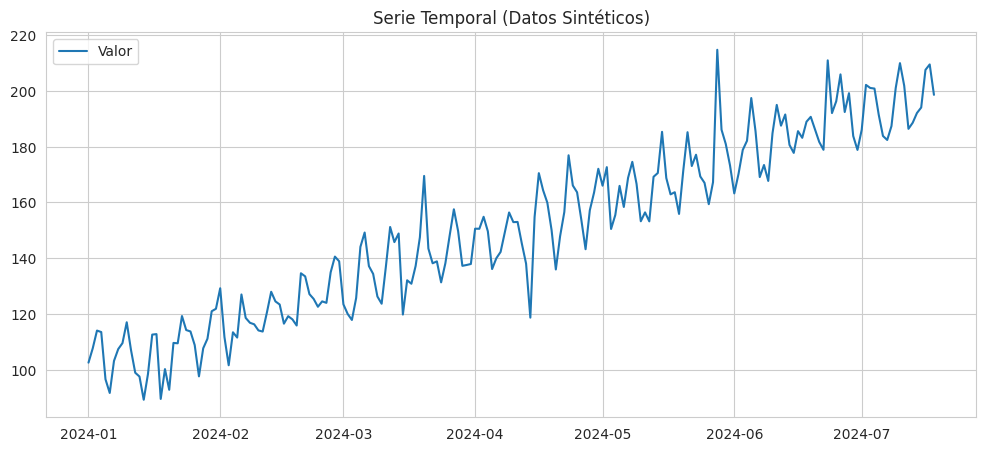

In [14]:
# Sección 2: Visualización de la serie
plt.figure(figsize=(12,5))
plt.plot(df.index, df['valor'], label='Valor')
plt.title("Serie Temporal (Datos Sintéticos)")
plt.legend()
plt.show()



### 2.1. Cálculo de z-score

El método z-score asume que la serie (o sus residuales) tienen una distribución aproximadamente normal. Si un punto excede cierto umbral (ej. z > 3), lo marcamos como anómalo.

Número de anomalías detectadas (z-score): 0


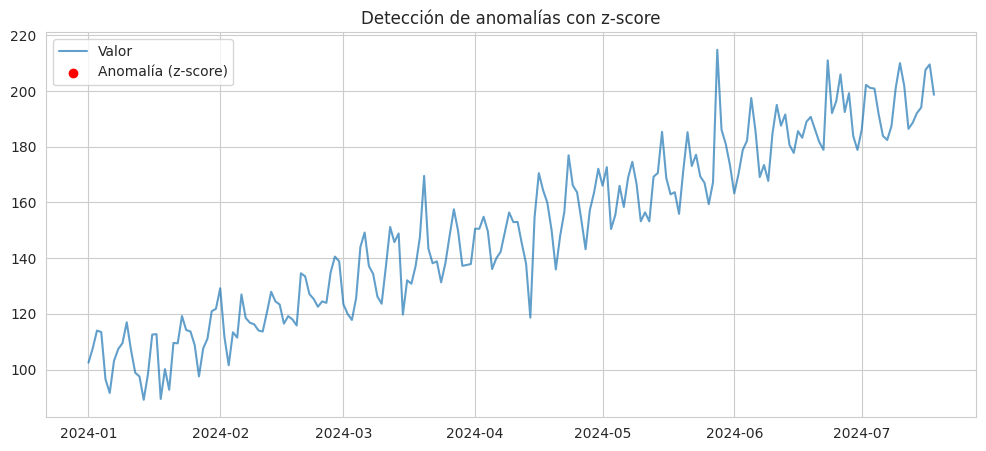

In [15]:
# Sección 2.1: z-score
df['z_score'] = zscore(df['valor'])
threshold = 3  # umbral típico
df['anomaly_z'] = (df['z_score'].abs() > threshold).astype(int)

print("Número de anomalías detectadas (z-score):", df['anomaly_z'].sum())

# Visualizamos en un plot
plt.figure(figsize=(12,5))
plt.plot(df.index, df['valor'], label='Valor', alpha=0.7)
plt.scatter(df.index[df['anomaly_z'] == 1],
            df['valor'][df['anomaly_z'] == 1],
            color='red', label='Anomalía (z-score)')
plt.title("Detección de anomalías con z-score")
plt.legend()
plt.show()


Si tenemos suerte, algunas anomalías (puntos muy altos o muy bajos) se verán a simple vista.

---

## Sección 3: Modelos Estadísticos Clásicos (ARIMA)

### 3.1. Breve explicación
- **ARIMA(p, d, q)** modela la serie como una combinación de partes autorregresivas (AR), diferencias (I) y medias móviles (MA).
- Para este ejemplo, **no** realizaremos un tuning completo de p, d, q. Solo mostraremos cómo ajustar un ARIMA simple con `statsmodels`.

### 3.2. Ejemplo: Ajuste ARIMA a nuestra serie


In [18]:
# Sección 3: Ajuste simple de un modelo ARIMA
# Para un ejemplo rápido, seleccionamos manualmente p, d, q:
p, d, q = 2, 1, 2

# Generamos la serie en un formato un poco más "clásico" para ARIMA (simple array)
serie = df['valor']

# Ajustamos el modelo
model = ARIMA(serie, order=(p, d, q))
results = model.fit()

print(results.summary())


                               SARIMAX Results                                
Dep. Variable:                  valor   No. Observations:                  200
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -701.217
Date:                Wed, 05 Feb 2025   AIC                           1412.433
Time:                        12:28:54   BIC                           1428.900
Sample:                    01-01-2024   HQIC                          1419.097
                         - 07-18-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1012      0.069     16.066      0.000       0.967       1.236
ar.L2         -0.6970      0.062    -11.268      0.000      -0.818      -0.576
ma.L1         -1.6307      0.070    -23.210      0.0

/home/caumel/anaconda3/envs/time_series_course/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


**Interpretación**:
- El output de `.summary()` nos da parámetros (AR, MA) y medidas de ajuste (AIC, BIC).
- Podríamos intentar diferentes órdenes (p,d,q) o usar funciones como `pmdarima` para auto-ARIMA, pero eso excede el enfoque de esta práctica.

### 3.3. Pronóstico con el ARIMA ajustado


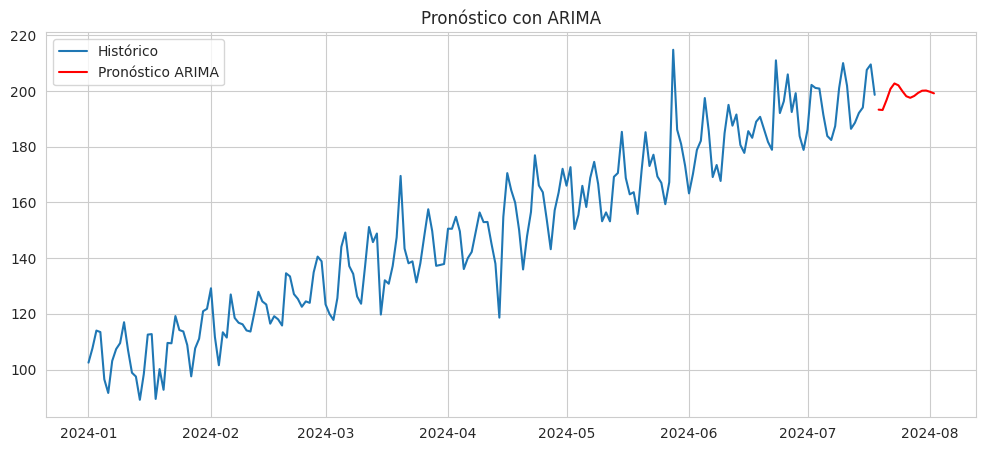

In [20]:
# Pronosticamos algunos días del futuro (ej. 15 días)
pred_steps = 15
forecast = results.forecast(steps=pred_steps)

# Construimos un DataFrame para visualización
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=pred_steps, freq='D')
forecast_df = pd.DataFrame({'forecast': forecast.values}, index=forecast_index)

# Graficamos
plt.figure(figsize=(12,5))
plt.plot(df.index, df['valor'], label='Histórico')
plt.plot(forecast_df.index, forecast_df['forecast'], label='Pronóstico ARIMA', color='red')
plt.legend()
plt.title('Pronóstico con ARIMA')
plt.show()


Vemos el resultado del modelo ARIMA (muy básico). No esperes una gran precisión si la serie contiene anomalías o si la estacionalidad no se manejó con SARIMA.  
Esto ilustra el **modelo estadístico clásico**.

---

## Sección 4: Modelo Supervisado Sencillo (Regresión Lineal)

### 4.1. Idea General
- Podemos tratar la predicción de la serie como un problema de **regresión supervisada**.
- Generamos features a partir de la propia serie (lags) y quizás alguna variable exógena (en este ejemplo, no la usaremos).

### 4.2. Construcción de Features


In [24]:
# Sección 4: Modelo supervisado sencillo

df_supervised = df.copy()

# Creamos características: consumo (t-1), consumo (t-2)
df_supervised['consumo_lag1'] = df_supervised['valor'].shift(1)
df_supervised['consumo_lag2'] = df_supervised['valor'].shift(2)

# Eliminamos filas iniciales con NaN por shift
df_supervised.dropna(inplace=True)

# Definimos X e y
X = df_supervised[['consumo_lag1', 'consumo_lag2']]
y = df_supervised['valor']

# Separamos un conjunto de entrenamiento y test (por ejemplo, 80% para entrenar)
split_index = int(len(df_supervised)*0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]


### 3.2. Entrenamiento de la Regresión

In [26]:

# Entrenamos modelo de regresión lineal
lr = LinearRegression()
lr.fit(X_train, y_train)

print("Coeficientes:", lr.coef_)
print("Intercepto:", lr.intercept_)


Coeficientes: [0.8620294  0.04861304]
Intercepto: 12.924286414712924


### 4.3. Predicción y visualización

MSE del modelo supervisado (Linear Regression): 116.67790392996093


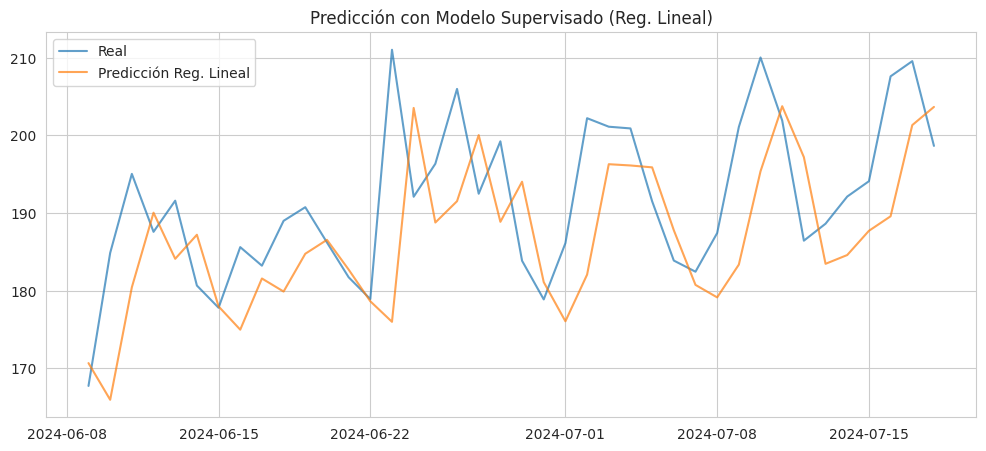

In [27]:
# Predicción en test
y_pred = lr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE del modelo supervisado (Linear Regression):", mse)

# Creamos DataFrame para comparar
df_pred = pd.DataFrame({'real': y_test, 'pred': y_pred}, index=y_test.index)

plt.figure(figsize=(12,5))
plt.plot(df_pred.index, df_pred['real'], label='Real', alpha=0.7)
plt.plot(df_pred.index, df_pred['pred'], label='Predicción Reg. Lineal', alpha=0.7)
plt.title('Predicción con Modelo Supervisado (Reg. Lineal)')
plt.legend()
plt.show()


**Comentario**:
- El modelo se basa únicamente en valores pasados (`lag1`, `lag2`); no tiene en cuenta estacionalidad a largo plazo ni anomalías explícitamente.
- Aun así, sirve para ilustrar cómo un **modelo supervisado** puede predecir la serie.

---

## Sección 5: Detección de Anomalías

Ahora que tenemos la serie (con algunos outliers inyectados), veremos dos enfoques:

1. **Método estadístico simple (z-score)**.  
2. **Isolation Forest** (no supervisado).

### 5.1. Método Estadístico (z-score)


Número de anomalías detectadas (z-score): 0


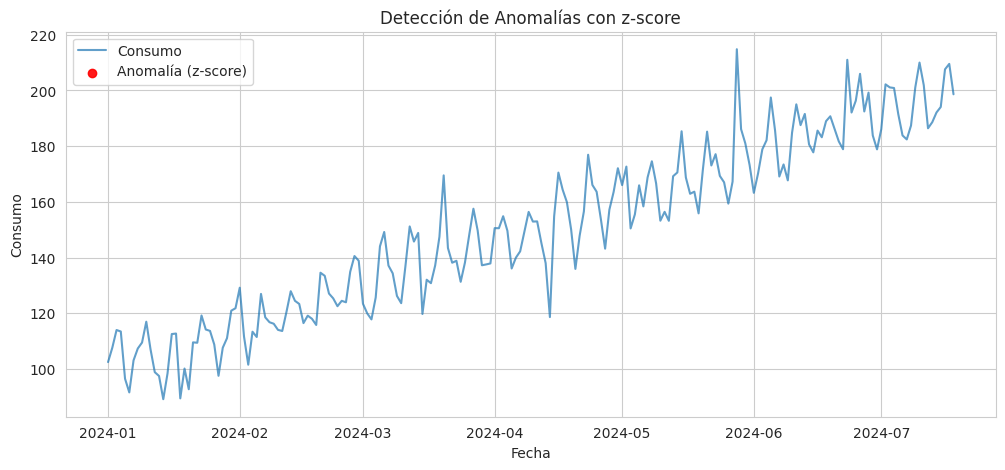

In [28]:
# Sección 5.1: Detección con z-score

df_anomalies = df.copy()
df_anomalies['z_score'] = zscore(df_anomalies['valor'])  # scipy.stats.zscore

threshold = 3  # más allá de +/-3 se puede considerar outlier
df_anomalies['anomaly_z'] = df_anomalies['z_score'].apply(lambda x: 1 if abs(x) > threshold else 0)

# Visualizamos cuántos outliers detectamos
print("Número de anomalías detectadas (z-score):", df_anomalies['anomaly_z'].sum())

# Graficamos la serie, resaltando anomalías
plt.figure(figsize=(12,5))
plt.plot(df_anomalies.index, df_anomalies['valor'], label='Consumo', alpha=0.7)

# Resaltamos en rojo los puntos outliers
plt.scatter(df_anomalies.index[df_anomalies['anomaly_z'] == 1],
            df_anomalies['valor'][df_anomalies['anomaly_z'] == 1],
            color='red', label='Anomalía (z-score)', alpha=0.9)

plt.title('Detección de Anomalías con z-score')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.show()


Observa que este método **asume** que la mayoría de los valores se distribuyen de forma aproximadamente normal.  
Si en tu serie hay estacionalidad o tendencia fuerte, es útil primero **centrar** la serie (por ejemplo, restarle la media móvil o usar los residuales).


### 5.2. Detectar Anomalías basadas en Residuales

Si la diferencia entre `real` y `pred` supera cierto umbral, podemos considerarla anómala. Aquí, por simplicidad, medimos z-score de los **residuales**.


Anomalías detectadas en test (residuales z-score): 1


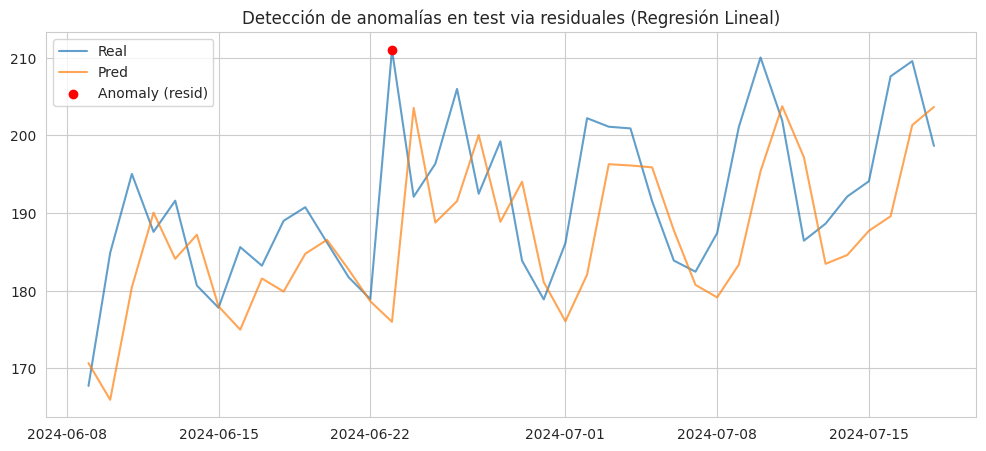

In [30]:
df_pred['resid'] = df_pred['real'] - df_pred['pred']
df_pred['resid_z'] = zscore(df_pred['resid'])

resid_threshold = 3
df_pred['anomaly_resid'] = (df_pred['resid_z'].abs() > resid_threshold).astype(int)

print("Anomalías detectadas en test (residuales z-score):", df_pred['anomaly_resid'].sum())

# Visualizamos
plt.figure(figsize=(12,5))
plt.plot(df_pred.index, df_pred['real'], label='Real', alpha=0.7)
plt.plot(df_pred.index, df_pred['pred'], label='Pred', alpha=0.7)

# Resaltar anomalías
anomalies = df_pred[df_pred['anomaly_resid'] == 1]
plt.scatter(anomalies.index, anomalies['real'], color='red', label='Anomaly (resid)', zorder=5)

plt.title("Detección de anomalías en test via residuales (Regresión Lineal)")
plt.legend()
plt.show()


Observa que estos “outliers” pueden o no coincidir con los detectados por z-score simple. Aquí, la anomalía se define como “donde el modelo se equivoca mucho”.

---


### 5.2. Detección con Isolation Forest

Un método **no supervisado** que “aísla” puntos anómalos más rápidamente que puntos normales en un bosque de árboles aleatorios.


Anomalías detectadas (Isolation Forest): 4


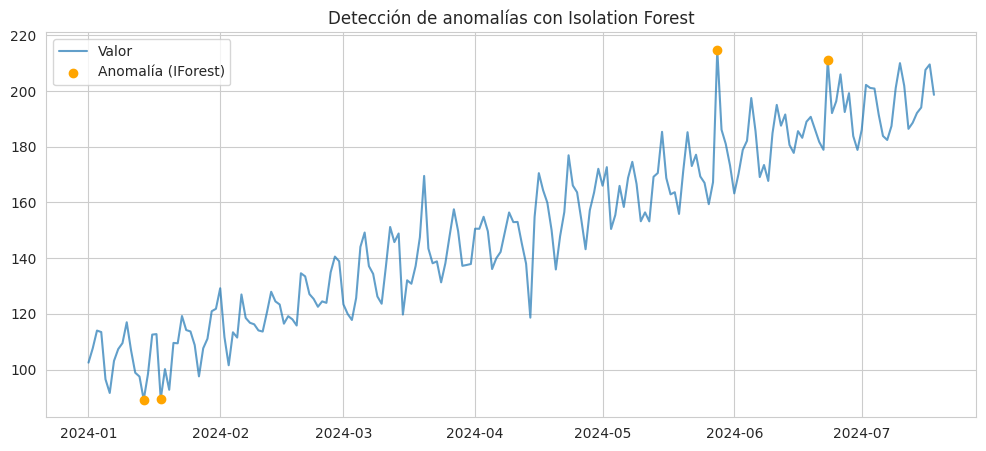

In [33]:
df_iforest = df.copy().dropna()

# IsolationForest requiere X en formato array
X_if = df_iforest[['valor']]  # aquí solo usamos 1 feature, la propia serie
iso_forest = IsolationForest(n_estimators=100, contamination=0.02, random_state=42)
iso_forest.fit(X_if)

# predict: -1 = anómalo, 1 = normal
df_iforest['anomaly_if'] = iso_forest.predict(X_if)
df_iforest['anomaly_if'] = df_iforest['anomaly_if'].apply(lambda x: 1 if x == -1 else 0)

print("Anomalías detectadas (Isolation Forest):", df_iforest['anomaly_if'].sum())

# Visualizamos
plt.figure(figsize=(12,5))
plt.plot(df_iforest.index, df_iforest['valor'], label='Valor', alpha=0.7)
plt.scatter(df_iforest.index[df_iforest['anomaly_if'] == 1],
            df_iforest['valor'][df_iforest['anomaly_if'] == 1],
            color='orange', label='Anomalía (IForest)', zorder=5)
plt.title("Detección de anomalías con Isolation Forest")
plt.legend()
plt.show()


**Comentarios**:
- Con `contamination=0.01`, forzamos a que ~1% de los datos sean considerados anómalos. Podemos ajustar este hiperparámetro según el dominio del problema.
- A diferencia del z-score, Isolation Forest no asume nada sobre la distribución de los datos, pero requiere un volumen razonable de muestras.

**Interpretación**:
- El parámetro `contamination=0.02` indica que asumimos ~2% de los puntos son atípicos.
- Ajusta según tu caso real.

---

## Sección 6: Comparación de Enfoques

Podemos comparar cuántos outliers se detectan y si coinciden.

### 6.1. Z-score vs. Residual-based vs. Isolation 

In [34]:
df_compare = pd.DataFrame({
    'z_score': df_anomalies['anomaly_z'],
    'iforest': df_iforest['anomaly_if']
}, index=df.index)

df_compare['match'] = (df_compare['z_score'] == df_compare['iforest']).astype(int)

print("Coincidencias en la etiqueta de anomalía:", df_compare['match'].sum(), "de", len(df_compare))

Coincidencias en la etiqueta de anomalía: 196 de 200


In [36]:
df_compare = pd.DataFrame(index=df.index)
df_compare['z_anomaly'] = df['anomaly_z'].fillna(0)
df_compare['iforest_anomaly'] = df_iforest['anomaly_if'].fillna(0)

# Residual-based anomalies solo se definió en test data
df_compare['resid_anomaly'] = 0
df_compare.loc[df_pred.index, 'resid_anomaly'] = df_pred['anomaly_resid'].fillna(0)

df_compare['sum'] = df_compare.sum(axis=1)
df_compare.head(10)


,z_anomaly,iforest_anomaly,resid_anomaly,sum
2024-01-01,0,0,0,0
2024-01-02,0,0,0,0
2024-01-03,0,0,0,0
2024-01-04,0,0,0,0
2024-01-05,0,0,0,0
2024-01-06,0,0,0,0
2024-01-07,0,0,0,0
2024-01-08,0,0,0,0
2024-01-09,0,0,0,0
2024-01-10,0,0,0,0


Observa la columna `sum`: si es 2 o 3, significa que varios métodos coinciden en marcar anomalía.

### 6.2. Gráficos Comparativos

Podrías crear un gráfico que marque en distintos colores los métodos que han detectado un outlier.


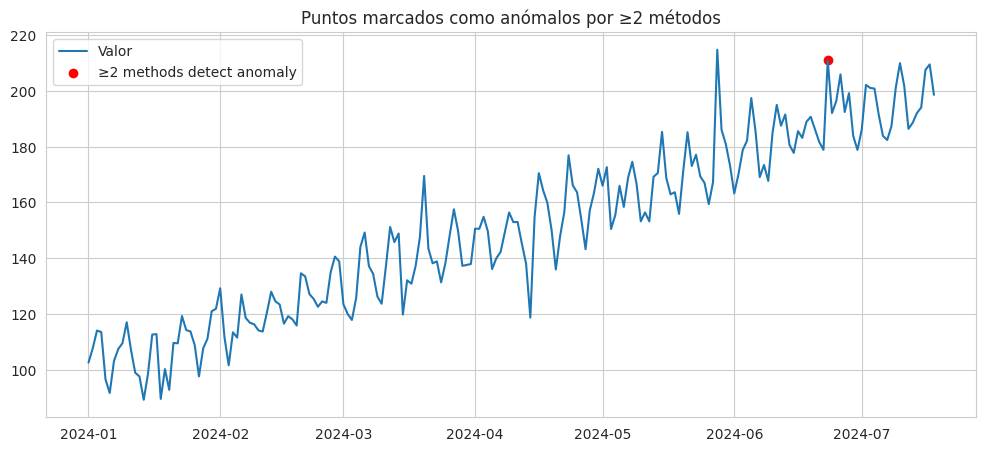

In [37]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df['valor'], label='Valor')
multi_anomalies = df_compare[df_compare['sum'] >= 2].index
plt.scatter(multi_anomalies, df.loc[multi_anomalies, 'valor'],
            color='red', label='≥2 methods detect anomaly')
plt.title("Puntos marcados como anómalos por ≥2 métodos")
plt.legend()
plt.show()

Posiblemente, algunos puntos marcados como anomalía por z-score no lo sean para Isolation Forest, y viceversa. Esto demuestra cómo los **métodos** tienen distintos supuestos y sensibilidades.

---

**Discusión**:
- Si un punto es capturado por z-score y residual-based, posiblemente sea un outlier claro.
- Isolation Forest puede detectar casos “más sutiles” o distintos.

---

## Sección 7: Conclusiones y Observaciones

1. **Z-score**: Rápido, fácil, asume ~distribución normal o al menos “estable”.
2. **Modelo supervisado**: Requiere lags/features, entrena una predicción. Si la serie difiere mucho de lo predicho → anómalo.  
3. **Isolation Forest**: No requiere supuestos de normalidad, define outliers como puntos aislados.

### ¿Cuál método es mejor?
- Depende del **contexto**, de si hay estacionalidad fuerte (necesitas removerla antes), de si tienes variable exógena, etc.  
- En la práctica, se prueban varios enfoques y se validan con datos conocidos.

---

## Sección 7: Tarea

1. **Aplicar** estos métodos al dataset personal (u otro real).
2. **Comparar** resultados y anotar cuántos outliers se detectan.
3. **Ajustar** hiperparámetros (ej. `contamination` en IsolationForest, `threshold` en z-score) y ver su efecto.
4. (Opcional) **Agregar** variables exógenas (fiestas, clima, etc.) al modelo supervisado para ver si mejora la detección.
